In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dropout, Dense
from keras import Model

2024-02-05 13:56:11.411298: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-05 13:56:11.411419: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-05 13:56:11.544420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
filename = "../input/sentiment-analysis-for-financial-news/all-data.csv"

df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

df_y = pd.get_dummies(df.sentiment, dtype=int)

X_train = list()
X_test = list()
y_train = list()
y_test = list()

In [3]:
for sentiment in ["positive", "neutral", "negative"]:
    train, test, train_target, test_target = train_test_split(
        df[df.sentiment==sentiment],
        df_y[df.sentiment==sentiment],
        train_size=300,
        test_size=300, 
        random_state=42)
    
    X_train.append(train)
    X_test.append(test)
    y_train.append(train_target)
    y_test.append(test_target)

In [4]:
X_train = pd.concat(X_train).sample(frac=1, random_state=10)
y_train = pd.concat(y_train).loc[X_train.index]
X_test = pd.concat(X_test)
y_test = pd.concat(y_test)

In [5]:
eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True), include_groups=False))
y_eval = df_y.loc[X_eval.index]

In [6]:
max_words = 10_000
max_len = 128

def tokenize_pad_sequences(text, tokenizer=None):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
        tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer


tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train.text)


X_train, tokenizer = tokenize_pad_sequences(X_train.text)
X_eval, _ = tokenize_pad_sequences(X_eval.text,tokenizer)
X_test, _ = tokenize_pad_sequences(X_test.text,tokenizer)

In [7]:
vocab_size = 10_000
embedding_size = 64

inputs = Input(shape=(max_len,))
embedding_layer = Embedding(vocab_size, embedding_size, input_length=max_len)(inputs)
conv1d_layer = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(embedding_layer)
maxpooling_layer = MaxPooling1D(pool_size=2)(conv1d_layer)
bidirectional_lstm_layer = Bidirectional(LSTM(32))(maxpooling_layer)
dropout_layer = Dropout(0.4)(bidirectional_lstm_layer)
outputs = Dense(3, activation='softmax')(dropout_layer)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

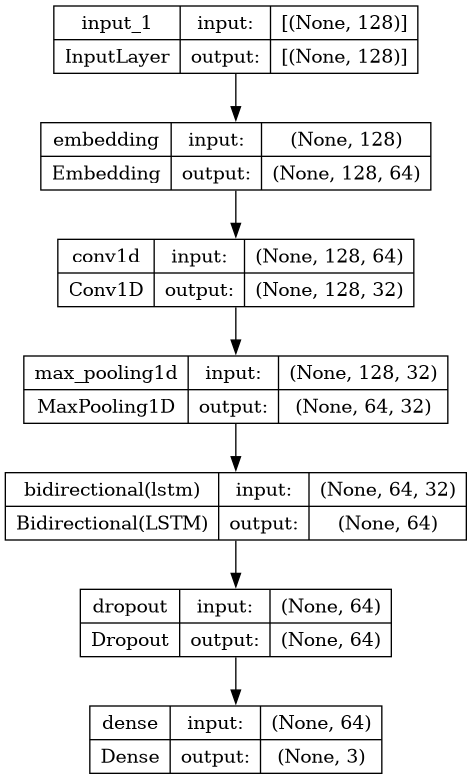

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
print(model.summary())

batch_size = 32
epochs = 100

early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_eval, y_eval),
                    batch_size=batch_size, epochs=epochs, verbose=1,
                    shuffle=True,
                    callbacks=[early_stop])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 64)           640000    
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           6176      
                                                                 
 max_pooling1d (MaxPooling1  (None, 64, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0     

I0000 00:00:1707141390.536748      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - 12s 195ms/step - loss: 1.0987 - accuracy: 0.3489 - val_loss: 1.0972 - val_accuracy: 0.3800
Epoch 2/100
29/29 [==============================] - 3s 112ms/step - loss: 1.0802 - accuracy: 0.4911 - val_loss: 1.0902 - val_accuracy: 0.3533
Epoch 3/100
29/29 [==============================] - 3s 91ms/step - loss: 0.9380 - accuracy: 0.6189 - val_loss: 1.0870 - val_accuracy: 0.4000
Epoch 4/100
29/29 [==============================] - 3s 101ms/step - loss: 0.6153 - accuracy: 0.7722 - val_loss: 1.1155 - val_accuracy: 0.5333
Epoch 5/100
29/29 [==============================] - 2s 61ms/step - loss: 0.2653 - accuracy: 0.9311 - val_loss: 1.1129 - val_accuracy: 0.6067
Epoch 6/100
29/29 [==============================] - 2s 58ms/step - loss: 0.1152 - accuracy: 0.9778 - val_loss: 1.3061 - val_accuracy: 0.6067
Epoch 7/100
29/29 [==============================] - 1s 44ms/step - loss: 0.0649 - accuracy: 0.9867 - val_loss: 1.2531 - val_accuracy: 0.6000
Epoch 8/100
29

In [10]:
y_pred = model.predict(X_test)

29/29 [==============================] - 1s 4ms/step


In [11]:
def evaluate(y_true, y_pred):
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [12]:
evaluate(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

Accuracy: 0.623
Accuracy for label 0: 0.620
Accuracy for label 1: 0.590
Accuracy for label 2: 0.660

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.62      0.69       300
           1       0.61      0.59      0.60       300
           2       0.53      0.66      0.59       300

    accuracy                           0.62       900
   macro avg       0.64      0.62      0.63       900
weighted avg       0.64      0.62      0.63       900


Confusion Matrix:
[[186  39  75]
 [ 23 177 100]
 [ 27  75 198]]
